# 4. Categorical iMM + Gibbs Sampling Algorithm

In [1]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd
import math 

import sys
print(sys.version)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


## 1. Hyperparameters


In [2]:
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [3]:
df = pd.read_csv('tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)


In [4]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)

### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

*Exercise:* Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result must be a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]

        
print('N: {} I: {}'.format(N, I))

N: 5568 I: 120


### Exercise 1.1
Derive the posterior $p( \boldsymbol{Z}, \boldsymbol{\Theta}| \boldsymbol{X})$

### Exercise 1.2
Derive the posterior $p(\boldsymbol{Z}| \boldsymbol{X})$

## Exercise 2
Implement the three algorithms in the boxes below (or in a separated python file that can be imported).

### Exercise 2.1: Algorithm 1 named gibbs_2 :

In [8]:

def log_likelihood_zn_theta(X_matrix, Thetas, K):
    
    """
    Computes the log-likelihood logP(x_n | z_n = k, Thetas[k]) for
    every document x_n and every cluster k.
    
    Arguments:
        X_matrix: np.ndarray, (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        Thetas: np.ndarray, (K x I), likelihood parameters for all cluster
    
    Returns:
        log_likelihoods: np.ndarray, (N x K), log_likelihoods[i, j] represents
            logP(x_i | z_i = j, Thetas[j])
    """
    N = X_matrix.shape[0]
    
    Thetas = np.array(Thetas).reshape(K,I)
    
    log_likelihoods = np.ones((N, K))
    
    
    for n, document in enumerate(X_matrix):
        
        c_n = np.repeat(document[np.newaxis, :], K, axis=0) # K x I
        log_likelihoods[n, :] = (c_n * np.log(Thetas)).sum(axis=1) # K
    
    return log_likelihoods #N x K


In [9]:
def log_marginal_likelihood_zn_theta(Xn, gamma):
    
    """
    Computes the marginal log-likelihood logP(x_n, Theta | z_n = k) for
    one document x_n and every cluster k over all possible values of Theta.
    
    Arguments:
        Xn: np.ndarray, (1 x I), Xn[j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the document.
        gamma: gamma hyperparameter
    
    Returns:
        integral log_likelihoods: np.ndarray, (1 x K), log_marginal_likelihood[j] represents
            logP(x_n | z_n = j)
    """

    gamma = gamma + Xn
    
    # compute sum_m sum_i log(gamma_m + i)
    summands_i = np.copy(Xn)
    mask = (Xn > 0)
    summands_i -= (summands_i > 0)
    log_s_m = mask*np.log(gamma + summands_i) # N x I
    
    while np.any(summands_i > 0):
        summands_i -= np.ones(Xn.shape)
        mask[summands_i < 0] = 0
        summands_i[summands_i < 0] = 0
            
        log_s_m += mask * np.log(gamma + summands_i) # N x I
    log_s_m = np.sum(log_s_m, axis=1) # N
              
    # compute sum_j log(j + sum_m gamma_m)
    summands_j = np.copy(Xn).sum(axis=1) # N
    mask = (summands_j > 0)
    summands_j -= (summands_j > 0)
    gamma_sum = gamma.sum(axis=1) # N
    log_w_n = mask*np.log(summands_j + gamma_sum)
    
    while np.any(summands_j > 0):
        summands_j -= np.ones(1)#(summands_j > 0)
        mask[summands_j < 0] = 0
        summands_j[summands_j < 0] = 0
            
        log_w_n += mask * np.log(summands_j + gamma_sum)
        
    # compute log_marginal-likelihoods
    log_marginal_likelihood = log_s_m - log_w_n
        
        
    return log_marginal_likelihood
        
        
    

In [10]:
def log_posterior_z_minus_n_for_known_clusters(Z, alpha, K, zn):
    """
    Computes the log-posterior logP(z_n = k | Z_minus_n) for all
    n and all k.
    
    Arguments:
        Z: np.ndarray (N), contains the cluster assignment of
            the documents
        alpha: np.ndarray (K), parameter for the prior distribution
            of Pi
        cluster_counts: np.ndarray (K), cluster_counts[i] is the number of
            documents in the i-th cluster
    Returns:
        log_posteriors: np.ndarray, (N x K), log_posteriors[i,j] represents
            logP(z_i = j | Z_minus_i)
    """
    
    N = Z.shape[0]
    
    cluster_counts = np.zeros(K, dtype=np.int)
    cluster, counts = np.unique(Z, return_counts=True)  
    cluster_counts[cluster] = counts  
    cluster_counts[zn] -=1
    
    log_posterior_z_minus_n = np.log(cluster_counts) - np.log( N - 1 + (alpha.sum()) )
        
    return  log_posterior_z_minus_n   #(1 x K)
        

In [11]:
def log_posterior_z_minus_n_for_new_cluster(X_matrix, Z, alpha):
    """
        Computes the logposterior P(z_n = k | Z_minus_n) for Xn and all k
        Arguments:
        Z: np.ndarray (N), contains the cluster assignment of the documents
        alpha: np.ndarray (K), parameter for the prior distribution of Pi
        cluster_counts: np.ndarray (K), cluster_counts[i] is the number of
        documents in the i-th cluster
    Returns:
        posteriors: np.ndarray, (1 x 1), posteriors[i] represents
            P(z_n = i | Z_minus_i)
    """
    R = X_matrix.shape[0]   
    log_posterior_z_minus_n =  np.log(alpha.sum()) - np.log( N - 1 + (alpha.sum()) ) 
    log_posterior_z_minus_n = np.array([log_posterior_z_minus_n])
    
    log_posterior_z_minus_n = np.repeat(log_posterior_z_minus_n[np.newaxis, :], R, axis=0) # (R x 1)   
    
    return  log_posterior_z_minus_n #(R x 1)

In [12]:
def sample_theta_k(X_matrix, Z, gamma, k):
    """
    Samples cluster parameters Theta_k from the posterior P(Theta_k | X, Z).
    
    Arguments:
        X_matrix: np.ndarray (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        Z: np.ndarray (N), contains the cluster assignment of
            the documents
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
        k: integer, cluster id
    
    Returns:
        Theta_k: np.ndarray (I), contains the parameters of the k-th
            cluster
    """
    # compute the number of occurances for each word in cluster k
    word_cluster_counts = X_matrix[np.where(Z == k), :].sum(axis=1)[0]
    gamma_new = gamma + word_cluster_counts

    return np.random.dirichlet(gamma_new, size=1)[0] #(1 x I)

In [13]:
def sample_theta_new(X_matrix, n, gamma):
    """
    Samples cluster parameters Theta_k_new from the posterior P(Theta_k_new | Xn).
    
    Arguments:
        X_matrix: np.ndarray (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
    
    Returns:
        Theta_k_new: np.ndarray (I), contains the parameters of the new
            cluster
    """
    # compute the number of occurances for each word in cluster k_new (i.e number of words in doc Xn)  
    word_cluster_counts = X_matrix[n]
    gamma_new = gamma + word_cluster_counts

    return np.random.dirichlet(gamma_new, size=1)[0]  #(1 x I)

In [14]:
def log_sum_exp(summands, axis=0):
    
    """
    Computes log(sum_i exp(summands[i])), using the log-sum-exp trick.
    
    Arguments:
        summands: np.ndarray, contains the summands
        axis: integer, the axis to sum over
        
    Returns:
        log_sum_exp: np.ndarray, the results of the summation
    """
    
    max_summand = np.max(summands)
    log_sum_exp = max_summand + np.log(np.exp(summands - max_summand).sum(axis=axis))
    
    return log_sum_exp

In [15]:
def exp_normalize(log_dist):
    """
    Computes exp(log_dist) / sum_i(log_dist[i]) using the exp-normalize trick.
    
    Arguments:
        log_dist: np.ndarray, (N x K), log-distribution that will be normalized
        
    Returns:
        norm_dist: np.ndarray, (log_dist.shape), the normalized distribution
    """
    K = log_dist.shape[1]
    
    max_val = np.repeat(np.max(log_dist, axis=1)[:, np.newaxis], K, axis=1) # (N x K)
    
    norm_dist = np.exp(log_dist - max_val) # (N x K)

    sum_exp = norm_dist.sum(axis=1) # (N)
    norm_dist /= np.repeat(sum_exp[:, np.newaxis], K, axis=1)

    return norm_dist

In [16]:
def posterior_zn_2(X_matrix, n, Thetas, K, gamma, alpha, Z):
    """
    Computes the posterior P(z_n = k| x_n, Z_minus_n, Theta) for all
    n and all k.
    
    Arguments:
        log_lik_zn_theta: np.ndarray, (N x K), log_lik_zn_theta[i, j] represents
            logP(x_i | z_i = j, Theta)
        log_post_z_minus_n: np.ndarray, (N x K), log_post_z_minus_n[i, j] represents
            logP(z_i = j | Z_minus_j)
        
    Returns:
        posteriors: np.ndarray, (N x K), posteriors[i, j] represents
            P(z_i = j | x_i, Z_minus_i, Theta)
    """
    
    dist1 =  log_likelihood_zn_theta(X_matrix[n][np.newaxis, :], Thetas, K) + log_posterior_z_minus_n_for_known_clusters(Z, alpha, K, Z[n])                                
    
    dist2 = log_marginal_likelihood_zn_theta(X_matrix[n][np.newaxis, :], gamma) + log_posterior_z_minus_n_for_new_cluster(X_matrix[n][np.newaxis, :], Z, alpha)    
    
    posterior_zn = np.zeros((1,K+1))
    posterior_zn[:,:-1] = dist1
    posterior_zn[0][K] = dist2
    

    return exp_normalize(posterior_zn)

In [17]:
def sample_z_2(post_zn_2):
    """
    Samples the cluster assignment z_n of x_n from the posterior 
    P(z_n | x_n, Z_-n, Theta).

    Arguments:
        post_zn: np.ndarray, (K), post_zn[i] represents
            p(z_n = i | x_n, Pi, Theta)
    Returns:
        z_n: integer, sampled cluster assignment of x_n
    """
    L = len(post_zn_2)
    return np.random.choice(np.arange(L), p=post_zn_2)

In [18]:
def log_likelihood(log_lik_zn_theta, Z):

    
    summands = log_lik_zn_theta # (N x K)
    summands = summands[np.arange(N), Z] # (N)
    return summands.sum()

In [19]:
def prepare_plot(ax, h):
    """
    Prepares the animated log-likelihood plot
    """
    ax[h].set_xlabel("Steps", fontweight='bold', fontsize=15)
    ax[h].set_ylabel("Log-likelihood", fontweight='bold', fontsize=15)
    line, = ax[h].plot([0], [0])
    
    lik = []
    
    return lik, line

In [20]:

def gibbs_2(X_matrix, alpha_value, fig, ax, h):
    
    # prepare likelihood plot animation
    lik_2, line = prepare_plot(ax, h)
        

    def animate(i):
        line.axes.set_xlim(0, i)
        line.axes.set_ylim(0.9 * np.min(lik_2), 1.1 * np.max(lik_2))
        line.axes.invert_yaxis()
        line.set_data(np.arange(i), lik_2[:i])         
            
    np.random.seed(1234)
    

    N, I = X_matrix.shape   
    
    gamma = np.ones(I)
    # sample Theta from prior
    Thetas = np.array( np.random.dirichlet(gamma, size=1)[0] )
    K = 1
    # sample Z from prior
    Z = np.repeat(0,N) # 1 x N
    # create alpha 
    alpha = (np.ones(K) / K) * alpha_value
    
    step = 1
    while(True):
        
        for n in range(N):
            posterior_zn = posterior_zn_2(X_matrix, n, Thetas, K, gamma, alpha, Z)
            Z[n] = sample_z_2(posterior_zn[0])
        
            if Z[n] == K : 
                theta = sample_theta_new(X_matrix, n, gamma)
                Thetas = np.vstack((Thetas, theta))
                K+=1
                alpha = (np.ones(K) / K) * alpha_value
    
        for k in range(K):
            Thetas[k] = sample_theta_k(X_matrix, Z, gamma, k)
        step +=1
        log_lik_zn_theta = log_likelihood_zn_theta(X_matrix, Thetas, K)       
        lik_2.append(log_likelihood(log_lik_zn_theta, Z))
        if (step) % 9 == 0:
            aux_list = lik_2[len(lik_2)-10 : len(lik_2)-1]
            if len(aux_list) == aux_list.count(aux_list[len(aux_list)-1]) : break 
            
        
        
        # plot likelihood
        animate(step-1)
        clear_output(wait=True)
        display(fig)
        plt.show()
        print(f"Iteration: {(step)} \t Log-likelihood: {lik_2[step-2]}")
    
    # plot likelihood
    animate(step-2)
    clear_output(wait=True)
    display(fig)
    print(f"Iteration: {(step)} \t Log-likelihood: {lik_2[step-2]}")

    return Z, lik_2, Thetas


### Exercise 2.2 For the First algorithm (gibbs_2):
Some useful packages:
- matplotlib https://matplotlib.org/
- seaborn https://github.com/mwaskom/seaborn
- wordcloud https://github.com/amueller/word_cloud
- probvis https://github.com/psanch21/prob-visualize

Here we run the Algorithm until convergence and plot the evolution of the likelihood per iteration (question a):

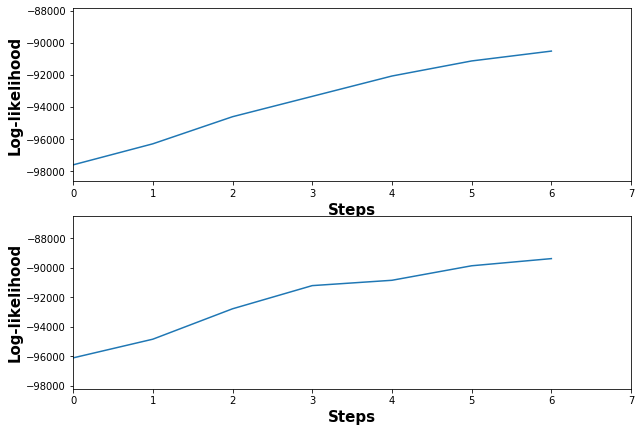

Iteration: 9 	 Log-likelihood: -89265.61502488866


In [21]:
%matplotlib notebook

from wordcloud import WordCloud
import math
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import display, clear_output


fig, ax = plt.subplots(2, 1, figsize=(10,7))

Thetas_result = []
K_plus = []
alpha_values = [ 0.1 , 10]
h = 0
for alpha_value in alpha_values:
    Z, lik_2, Thetas = gibbs_2(X_matrix, alpha_value, fig, ax, h)
    h+=1
    
    cluster_counts = np.zeros(Thetas.shape [0], dtype=np.int)
    cluster, counts = np.unique(Z, return_counts=True)  
    cluster_counts[cluster] = counts 
    indices = np.where(cluster_counts == 0)[0]
    X = np.ma.masked_equal(cluster_counts,0)
    X = X.compressed()
    Thetas = np.delete(Thetas, indices, 0)
    
    K_plus.append(X.size)
    Thetas_result.append(Thetas)  


Here we plot the 10 most representative words from each topic from a sample (question b)

In [41]:
%matplotlib inline
tweet_array = np.array(df_data['tweet'].values)
for thetas in Thetas_result :
    P = 4
    ToPlot = [thetas[n:n+P] for n in range(0, thetas.shape[0], P)]
    print('This is a collection of Plots for the alpha value :', alpha_values[Thetas_result.index(thetas)])
    print()
    for e in ToPlot:
        
        fig, ax = plt.subplots( 1, 4, figsize=(100,100))
        for k in range(e.shape[0]):
            
            theta_k = e[k]
            # get indices of 10 most representative words
            ind = np.argsort(-theta_k)[:10]
    
            words = [dictionary[i] for i in ind]     
            frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
        

            # generate wordcloud
            wordcloud = WordCloud().generate_from_frequencies(frequencies)
        
           
            ax[k].imshow(wordcloud, interpolation='bilinear')
            ax[k].axis("off")
        

    plt.show()

Here we plot the alpha vs. number of clusters for the Algorithm (question c): 

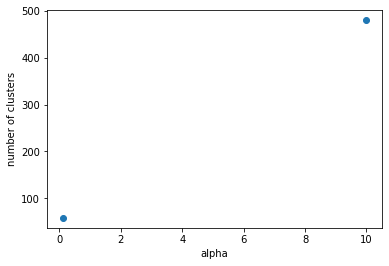

In [23]:
plt.figure()
plt.scatter(alpha_values, K_plus)
plt.xlabel("alpha")
plt.ylabel("number of clusters")
plt.show()

### Exercise 2.1: Algorithm 2 named gibbs_3 : 

In [24]:
def log_likelihood_zn_Xmn_Zmn(X_matrix, Xn, n,  Z, gamma, K):
    """
    Computes the log-likelihood logP(x_n | z_n = k, X_-n, Z_-n) for Xn.
    
    Arguments:
        X_matrix: np.ndarray, (N x I), X_matrix[i, j] represents the 
            number of occurences of the j-th word of the dictionary in 
            the i-th document.
        Xn : the current element (1,N)
        n : indice of the current element
        Z: np.ndarray (N), contains the cluster assignments
        gamma: np.ndarray (I), parameter for the prior distribution
            of Theta
        K: integer, number of clusters 
        
    Returns:
        log_likelihoods: np.ndarray, (1 x K), log_likelihoods[j]
            represents logP(x_n| z_i = j, X_-n, Z_-n) 
    """
    N, I = X_matrix.shape
    log_likelihoods = np.zeros((1, K))
    
    
    for k in range(K):
        
        # compute gamma_dash
        X_k = X_matrix[(Z == k), :]
        gamma_dash = X_k.sum(axis=0) # 1 x I 
        #if Z[n] == k : gamma_dash[k] -= 1
        gamma_dash = gamma_dash + gamma

        
        # compute sum_m sum_i log(gamma_m + i)
        summands_i = np.copy(Xn)
        mask = (Xn > 0)
        summands_i -= (summands_i > 0)
        log_s_m = mask*np.log(gamma_dash + summands_i    +   1e-7) # 1 x I
    
        while np.any(summands_i > 0):
            summands_i -= np.ones(Xn.shape)
            mask[summands_i < 0] = 0
            summands_i[summands_i < 0] = 0
            
            log_s_m += mask * np.log(gamma_dash + summands_i) # 1 x I
        log_s_m = np.sum(log_s_m, axis=1) # 1
        
        
        # compute sum_j log(j + sum_m gamma_m)
        summands_j = np.copy(Xn).sum(axis=1) # 1
        
        mask = (summands_j > 0)
        summands_j -= (summands_j > 0)
        gamma_sum = gamma_dash.sum(axis=0) # 1
        log_w_n = mask*np.log(summands_j + gamma_sum    +  1e-7)
        
        while np.any(summands_j > 0):
            summands_j -= np.ones(1)#(summands_j > 0)
            mask[summands_j < 0] = 0
            summands_j[summands_j < 0] = 0
            
            log_w_n += mask * np.log(summands_j + gamma_sum)
            
        # compute log-likelihoods
        log_likelihoods[:,k] = log_s_m - log_w_n
        
    return log_likelihoods

In [25]:
def posterior_zn_3(X_matrix, n, K, gamma, alpha, Z):
    """
    Computes the posterior P(z_n = k| x_n, Z_minus_n, Theta) for all
    n and all k.
    
    Arguments:
        log_lik_zn_theta: np.ndarray, (N x K), log_lik_zn_theta[i, j] represents
            logP(x_i | z_i = j, Theta)
        log_post_z_minus_n: np.ndarray, (N x K), log_post_z_minus_n[i, j] represents
            logP(z_i = j | Z_minus_j)
        
    Returns:
        posteriors: np.ndarray, (N x K), posteriors[i, j] represents
            P(z_i = j | x_i, Z_minus_i, Theta)
    """
    
    
    dist1 = log_likelihood_zn_Xmn_Zmn(X_matrix, X_matrix[n][np.newaxis, :], n, Z, gamma, K) + log_posterior_z_minus_n_for_known_clusters(Z, alpha, K, Z[n])

    
    dist2 =  log_marginal_likelihood_zn_theta(X_matrix[n][np.newaxis, :], gamma) +  log_posterior_z_minus_n_for_new_cluster(X_matrix[n][np.newaxis, :], Z, alpha)                                  
    
    
    
    posterior_zn = np.zeros((1,K+1))
    posterior_zn[:,:-1] = dist1
    posterior_zn[0][K] = dist2
    
    

    return exp_normalize(posterior_zn)

In [26]:
def sample_z_3(post_zn_3):
    """
    Samples the cluster assignment z_n of x_n from the posterior 
    P(z_n | x_n, Z_-n, Theta).

    Arguments:
        post_zn: np.ndarray, (K), post_zn[i] represents
            p(z_n = i | x_n, Pi, Theta)
    Returns:
        z_n: integer, sampled cluster assignment of x_n
    """
    L = len(post_zn_3)
    return np.random.choice(np.arange(L), p=post_zn_3)

In [44]:
def gibbs_3(X_matrix, alpha_value, fig, ax, h):
    
    
    # prepare likelihood plot animation
    lik_3, line = prepare_plot(ax, h)
    
    
    def animate(i):
        line.axes.set_xlim(0, i)
        line.axes.set_ylim(0.9 * np.min(lik_3), 1.1 * np.max(lik_3))
        line.axes.invert_yaxis()
        line.set_data(np.arange(i), lik_3[:i])
            
            
    np.random.seed(1234)
    

    N, I = X_matrix.shape   
    
    gamma = np.ones(I)
    # sample Theta from prior
    Thetas = np.array( np.random.dirichlet(gamma, size=1)[0] )
    K = 1
    # sample Z from prior
    Z = np.repeat(0,N) # 1 x N
    # create alpha 
    alpha = (np.ones(K) / K) * alpha_value
    
    step = 1
    while(True):
        
        for n in range(N):
            posterior_zn = posterior_zn_3(X_matrix, n, K, gamma, alpha, Z)
            Z[n] = sample_z_3(posterior_zn[0])
        
            if Z[n] == K : 
                K+=1
                alpha = (np.ones(K) / K) * alpha_value
                 
    
        Thetas = np.zeros((K, I))       
        for k in range(K):
            # sample likelihood parameters Theta_k
            Thetas[k] = sample_theta_k(X_matrix, Z, gamma, k) # I
            
        log_lik_zn_theta = log_likelihood_zn_theta(X_matrix, Thetas, K)
        log_lik = log_likelihood(log_lik_zn_theta, Z)
        lik_3.append(log_lik)
        
        step +=1
        print(step)
        if (step) % 9 == 0:
            aux_list = lik_3[len(lik_3)-10 : len(lik_3)-1]
            if len(aux_list) == aux_list.count(aux_list[len(aux_list)-1]) : break 
        

        animate(step-1)
        clear_output(wait=True)
        display(fig)
        plt.show()
        print(f"Iteration: {(step)} \t Log-likelihood: {lik_3[step-2]}")
    
    # plot likelihood
    animate(step-2)
    clear_output(wait=True)
    display(fig)
    plt.show()
    print(f"Iteration: {(step)} \t Log-likelihood: {lik_3[step-2]}")


    return Z, lik_3, Thetas


### Exercise 2.2 For the Second algorithm (gibbs_3):
Some useful packages:
- matplotlib https://matplotlib.org/
- seaborn https://github.com/mwaskom/seaborn
- wordcloud https://github.com/amueller/word_cloud
- probvis https://github.com/psanch21/prob-visualize

Here we run the Algorithm until convergence and plot the evolution of the likelihood per iteration (question a):

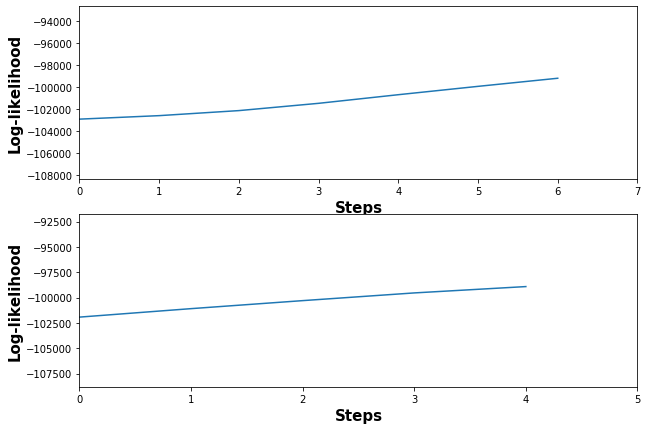

Iteration: 6 	 Log-likelihood: -98919.99825641079


In [ ]:
%matplotlib inline

from wordcloud import WordCloud
import math
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import display, clear_output


fig, ax = plt.subplots(2, 1, figsize=(10,7))

Thetas_result = []
K_plus = []
alpha_values = [ 0.1 , 10 ]
h = 0
for alpha_value in alpha_values:
    Z, lik_3, Thetas = gibbs_3(X_matrix, alpha_value, fig, ax, h)
    h+=1
    
    cluster_counts = np.zeros(Thetas.shape [0], dtype=np.int)
    cluster, counts = np.unique(Z, return_counts=True)  
    cluster_counts[cluster] = counts 
    indices = np.where(cluster_counts == 0)[0]
    X = np.ma.masked_equal(cluster_counts,0)
    X = X.compressed()
    Thetas = np.delete(Thetas, indices, 0)
    
    K_plus.append(X.size)
    Thetas_result.append(Thetas) 


Here we plot the 10 most representative words from each topic from a sample (question b)

In [ ]:
%matplotlib inline
tweet_array = np.array(df_data['tweet'].values)
for thetas in Thetas_result :
    P = 4
    ToPlot = [thetas[n:n+P] for n in range(0, thetas.shape[0], P)]
    print('This is a collection of Plots for the alpha value :', alpha_values[Thetas_result.index(thetas)])
    print()
    for e in ToPlot:
        
        fig, ax = plt.subplots( 1, 4, figsize=(100,100))
        for k in range(e.shape[0]):
            
            theta_k = e[k]
            # get indices of 10 most representative words
            ind = np.argsort(-theta_k)[:10]
    
            words = [dictionary[i] for i in ind]     
            frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
        

            # generate wordcloud
            wordcloud = WordCloud().generate_from_frequencies(frequencies)
        
           
            ax[k].imshow(wordcloud, interpolation='bilinear')
            ax[k].axis("off")
        

    plt.show()


Here we plot the alpha vs. number of clusters for the Algorithm (question c):

In [ ]:
plt.figure()
plt.scatter(alpha_values, K_plus)
plt.xlabel("alpha")
plt.ylabel("number of clusters")
plt.show()